# Part 1: Camera calibration (Intrinsic parameters)

In [3]:
import numpy as np
import cv2
import glob
import os

In [4]:
print(cv2.__version__)

3.3.0


In [5]:
from platform import python_version
print(python_version())

3.6.3


In [6]:
 # termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

In [7]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.


In [8]:
images = glob.glob('./Chessboard3/*.JPG')


In [9]:
print(images)

['./Chessboard3/IMG_1068.JPG', './Chessboard3/IMG_1069.JPG', './Chessboard3/IMG_1057.JPG', './Chessboard3/IMG_1061.JPG', './Chessboard3/IMG_1060.JPG', './Chessboard3/IMG_1062.JPG', './Chessboard3/IMG_1063.JPG', './Chessboard3/IMG_1067.JPG', './Chessboard3/IMG_1066.JPG', './Chessboard3/IMG_1072.JPG', './Chessboard3/IMG_1064.JPG', './Chessboard3/IMG_1070.JPG', './Chessboard3/IMG_1059.JPG', './Chessboard3/IMG_1071.JPG', './Chessboard3/IMG_1065.JPG']


In [10]:
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners,ret)
        name = fname.replace("./Chessboard/","")
        cv2.imwrite("./res/part 1/"+str(name),img)
        #print("./res/part 1/"+str(name)+".png")
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
        #cv2.destroyAllWindows()

In [11]:
 ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [12]:
print(ret)


1.628830895986753


In [13]:
print(mtx)

[[2.35823484e+03 0.00000000e+00 1.27505685e+03]
 [0.00000000e+00 2.35363433e+03 9.73403504e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [14]:
print(dist)

[[ 0.10990381 -0.01088416 -0.00567028 -0.00663648 -1.30729001]]


In [15]:
[ 0.10990381 -0.01088417 -0.00567028 -0.00663648 -1.30729001]

[-1.22057713]

In [16]:
principalPoint = (mtx[0][2],mtx[1][2])

In [17]:
focal = (mtx[0][0]+mtx[1][1])/2

In [18]:
print(principalPoint)

(1275.0568472391526, 973.4035044444332)


In [19]:
img = cv2.imread('./Chessboard3/IMG_1068.JPG')

In [20]:
dstchess = cv2.undistort(img, mtx, dist)
cv2.imwrite('./calibresult/mytest.png',dstchess)

True

# Part 2: Take the pictures

# Part 3: Compute the relative camera pose

In [21]:
from matplotlib import pyplot as plt

imgo1 = cv2.imread('./Pair image2/myleft.JPG')  #queryimage # left image
imgo2 = cv2.imread('./Pair image2/myright.JPG') #trainimage # right image


## 3.1 undistort the picture

In [22]:
# undistort
dst1 = cv2.undistort(imgo1, mtx, dist)
cv2.imwrite('./calibresult/myleft.png',dst1)
# undistort
dst2 = cv2.undistort(imgo2, mtx, dist)
cv2.imwrite('./calibresult/myright.png',dst1)

True

In [23]:

img1 = cv2.imread('./calibresult/0.JPG')  #queryimage # left image
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img2 = cv2.imread('./calibresult/1.JPG') #trainimage # right image
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

In [24]:
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.5*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)


In [25]:
print(pts1)

[[1926  462]
 [1130  439]
 [1180  441]
 ...
 [1370 1346]
 [ 658 1699]
 [1207  724]]


Got the list of best matches from both images

In [26]:

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

In [27]:
print(F)

[[-3.84128923e-08  2.54493575e-06 -6.20588721e-04]
 [-7.91415426e-07  6.66958672e-08 -1.59205797e-02]
 [ 1.21834113e-05  1.26101212e-02  1.00000000e+00]]


Next we find the epilines. Epilines corresponding to the points in first image is drawn on second image. So mentioning of correct images are important here. We get an array of lines. So we define a new function to draw these lines on the images.

In [28]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

Now we find the epilines in both the images and draw them.

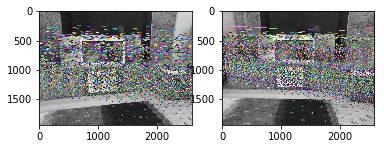

In [29]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
cv2.imwrite("./res/part 2/epilineleft.png", img5)
cv2.imwrite("./res/part 2/epilineright.png", img3)
plt.show()
cv2.destroyAllWindows()

Compute the essential matrix E
https://docs.opencv.org/3.1.0/d9/d0c/group__calib3d.html#ga13f7e34de8fa516a686a56af1196247f

In [30]:
E, mask = cv2.findEssentialMat(pts1, pts2, focal, principalPoint, method=cv2.RANSAC, prob=0.999, threshold=3.0)

In [31]:
print(E)

[[ 0.00344321  0.27292553  0.05371569]
 [-0.10668505  0.00622317 -0.69677576]
 [-0.01352015  0.65216834 -0.01382731]]


In [32]:
R1,R2,t = cv2.decomposeEssentialMat(E)

### decompose the essential matrix, we got two rotaion matrixs, R1(3*3) and R2(3*3), and one translation vector (3*1).
### We need the  projection matrix of the first camera and projection matrix of the second camera to calculate the triangulatePoints
### projMatr1 – 3x4 projection matrix of the first camera.
### projMatr2 – 3x4 projection matrix of the second camera.

In [33]:
print(R1)

[[ 0.84899521  0.09170774 -0.52038143]
 [ 0.09331245 -0.99536707 -0.02317731]
 [-0.52009608 -0.02888064 -0.85361934]]


In [34]:
print(R2)

[[ 9.68320962e-01 -5.99263511e-02  2.42411525e-01]
 [ 6.19095553e-02  9.98081604e-01 -5.64872089e-04]
 [-2.41912633e-01  1.55545672e-02  9.70173352e-01]]


In [35]:
print(t)

[[ 0.91936328]
 [ 0.07852536]
 [-0.38549309]]


### There are 4 possible combination for the projection matrix.
#### Case 1:  projMatr1 = K [ I 0]   projMatr2 = K[R1 t]
#### Case 2:  projMatr1 = K[ I 0]   projMatr2 = K[R1  -t]
#### Case 3:  projMatr1 = K[ I 0]   projMatr2 = K[R2 t]
#### Case 4:  projMatr1 = K[ I 0]   projMatr2 = K[R2 -t]


In [36]:
points1 = np.array(pts1).astype(float).T 
points2 = np.array(pts2).astype(float).T

In [37]:
# make a projection matrix for camera 1
projMatr1 = mtx@np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])

In [38]:
# case 1
projMatr21 = mtx@np.concatenate((R1,t),1)
# case 2
projMatr22 = mtx@np.concatenate((R1,-t),1)
# case 3
projMatr23 = mtx@np.concatenate((R2,t),1)
# case 4
projMatr24 = mtx@np.concatenate((R2,-t),1)

In [39]:
triangulate1 = cv2.triangulatePoints(projMatr1, projMatr21,points1,points2)
triangulate2 = cv2.triangulatePoints(projMatr1, projMatr22,points1,points2)
triangulate3 = cv2.triangulatePoints(projMatr1, projMatr23,points1,points2)
triangulate4 = cv2.triangulatePoints(projMatr1, projMatr24,points1,points2)

In [40]:
print(triangulate1.T)

[[-0.2600651   0.20484928 -0.94217022  0.0521362 ]
 [ 0.05114042  0.18855837 -0.83146966 -0.52008519]
 [ 0.03416712  0.19172311 -0.84764941 -0.49352339]
 ...
 [-0.1263581   0.03288221  0.74855415  0.65009159]
 [-0.08175165 -0.12419548 -0.93623582 -0.31836245]
 [-0.0364933  -0.14385459 -0.9067541  -0.39467847]]


In [41]:
print(triangulate1[2].min())

-0.97380087294087


#### case 1 got negtive distance, get rid of it.

In [42]:
print(triangulate2.T)

[[-0.2600651   0.20484928 -0.94217022 -0.0521362 ]
 [ 0.05114042  0.18855837 -0.83146966  0.52008519]
 [ 0.03416712  0.19172311 -0.84764941  0.49352339]
 ...
 [ 0.1263581  -0.03288221 -0.74855415  0.65009159]
 [-0.08175165 -0.12419548 -0.93623582  0.31836245]
 [-0.0364933  -0.14385459 -0.9067541   0.39467847]]


In [43]:
print(triangulate2[2].min())

-0.97380087294087


#### case 2 got negtive distance, get rid of it.

In [44]:
print(triangulate3.T)

[[-0.25672644  0.20221947 -0.93007485  0.16780822]
 [ 0.05883805  0.2169404  -0.95662346  0.18532812]
 [ 0.03861181  0.21666374 -0.95791735  0.18428323]
 ...
 [ 0.1620439  -0.04216877 -0.9599601   0.22458891]
 [-0.08435993 -0.12815784 -0.96610567  0.20760253]
 [-0.03882966 -0.15306393 -0.96480303  0.21028266]]


In [45]:
print(triangulate3[2].min())

-0.9768236085989586


#### case 3 got negtive distance, so I get rit of this case.

In [46]:
print(triangulate4.T)

[[-0.25672644  0.20221947 -0.93007485 -0.16780822]
 [ 0.05883805  0.2169404  -0.95662346 -0.18532812]
 [ 0.03861181  0.21666374 -0.95791735 -0.18428323]
 ...
 [ 0.1620439  -0.04216877 -0.9599601  -0.22458891]
 [-0.08435993 -0.12815784 -0.96610567 -0.20760253]
 [-0.03882966 -0.15306393 -0.96480303 -0.21028266]]


In [47]:
print(triangulate4[2].min())

-0.9768236085989586


#### case 4 has the positive distance , so the (R2,-t) is the right R and t

In [48]:
print(triangulate4.T)

[[-0.25672644  0.20221947 -0.93007485 -0.16780822]
 [ 0.05883805  0.2169404  -0.95662346 -0.18532812]
 [ 0.03861181  0.21666374 -0.95791735 -0.18428323]
 ...
 [ 0.1620439  -0.04216877 -0.9599601  -0.22458891]
 [-0.08435993 -0.12815784 -0.96610567 -0.20760253]
 [-0.03882966 -0.15306393 -0.96480303 -0.21028266]]


In [49]:
triangulate4world = np.true_divide(triangulate4.T[:,:3], triangulate4.T[:,[-1]]).T

In [50]:
print(triangulate4world.T.min())

-2.2195854566453446


In [51]:
print(triangulate4world.shape)

(3, 944)


In [52]:
pixelh = mtx@triangulate4world

In [53]:
print(pixelh.T)

[[1.06748020e+04 2.55879846e+03 5.54248675e+00]
 [5.83287275e+03 2.26939254e+03 5.16178252e+00]
 [6.13372876e+03 2.29262796e+03 5.19807117e+00]
 ...
 [3.74847595e+03 4.60253533e+03 4.27429877e+00]
 [6.89192088e+03 5.98281421e+03 4.65363157e+00]
 [6.28557861e+03 6.17929780e+03 4.58812457e+00]]


In [54]:
pixel = np.true_divide(pixelh.T[:,:2],pixelh.T[:,[-1]])

In [55]:
print(points1.T)

[[1926.  462.]
 [1130.  439.]
 [1180.  441.]
 ...
 [ 877. 1076.]
 [1481. 1285.]
 [1370. 1346.]]


In [56]:
print(pixel)

[[1925.99504319  461.66974762]
 [1130.01133377  439.65287915]
 [1180.00092092  441.05359219]
 ...
 [ 876.98033082 1076.79307835]
 [1480.97690391 1285.62266192]
 [1369.96685853 1346.8025348 ]]


In [57]:
print(pixel.shape)

(944, 2)


In [58]:
imgleft = cv2.imread('./Pair image2/myleft.JPG')  # left image
imgright = cv2.imread('./Pair image2/myright.JPG') # right image



In [59]:
cv2.imshow('left',imgleft)

In [60]:
for point in pixel.astype(int):
    #print(tuple(point))
    
    imgleft = cv2.circle(imgleft,tuple(point),10,(0, 0, 200),-1)
for point in points1.T.astype(int):
    #print(tuple(point))
    imgleft = cv2.circle(imgleft,tuple(point),5,(200, 0, 0),-1)
cv2.imwrite("./res/part 3/reporject.png", imgleft)
#plt.imshow(imgleft)
#cv2.imshow('left',imgleft )
#cv2.waitKey(0)
#cv2.destroyAllWindows()


True

# Part 4: Plane-sweeping stereo

### 4.1 compute 20 depth to generate a array of 20 depth

In [61]:
print(triangulate4world[2])

[5.54248675 5.16178252 5.19807117 5.20483518 5.5767724  5.70650505
 4.6781098  4.6781098  5.67250014 5.71299389 4.69712411 3.9585724
 3.9585724  4.80845309 4.02247122 4.72677651 5.51658653 5.4877086
 5.50300728 5.48193327 5.58598817 5.52807114 4.97346296 4.98545852
 5.07446468 5.03833366 5.09631605 5.09631605 5.13873917 5.19804667
 5.15441706 5.07981949 5.20884446 5.01252321 4.97533697 5.1753005
 5.1753005  4.99075234 5.16552616 5.70651071 5.60469696 5.6094571
 5.6094571  5.58859128 4.63516089 4.5679999  4.53771657 4.64004264
 4.56539528 4.69693826 4.64985856 4.65429529 4.70388425 4.70388425
 4.64775761 4.68352392 4.61579162 4.60600141 4.59939442 5.83410143
 4.68553833 4.68553833 5.65085439 4.72544331 4.58581517 5.74805178
 4.74004764 4.73373707 4.73870859 5.7440464  5.7440464  4.60444769
 5.68986139 5.92119614 4.66078039 5.76210493 4.67216892 4.73875411
 4.6912744  4.90374232 4.5790121  4.6427594  4.66962477 4.35447487
 4.72508769 4.81742761 4.24884044 4.64275082 4.16588405 4.5078987


In [62]:
dmin = triangulate4world[2].min()

In [63]:
dmax = triangulate4world[2].max()

In [64]:
ddepth = (dmax - dmin)/19

In [65]:
n = [0,0,1]

In [66]:
print("dmin: ", dmin, "dmax: ", dmax, "ddepth: ", ddepth)

dmin:  3.3684935610743167 dmax:  5.979697809617511 ddepth:  0.13743180255490495


In [67]:
def darray(dmin, dmax,number):
    da = []
    ddepth = (dmax - dmin)/19
    for i in range(number):
        da.append(dmin+i*ddepth)
    return da

In [68]:
deptharray = darray(0,dmax,20)

In [69]:
from numpy.linalg import inv

In [70]:
def Homo(k,R2,t,n,depth):
    pmatrix1 = np.concatenate((R2,-t), axis=1)
    pmatrix2 = np.append(n,depth).reshape(1,4)
    p = np.concatenate([pmatrix1,pmatrix2])
    H = p@inv(p)
    H = H[0:3,0:3]
    Homo = k@H@inv(k)
    return Homo

In [71]:
Homo1 = Homo(mtx,R2,t,n,deptharray[18])

In [72]:
print(Homo1)

[[ 1.00000000e+00  4.31370810e-18  0.00000000e+00]
 [ 5.19401800e-18  1.00000000e+00  2.27373675e-13]
 [ 0.00000000e+00 -4.60650220e-23  1.00000000e+00]]


In [73]:
print(deptharray[3])

0.9441628120448702


In [74]:
for d in deptharray:
    Hh = Homo(mtx,R2,t,n,d)
    warpname = str(d).replace(".","")
    print(warpname)
    print("./res/part 4/warp"+warpname+".png")

00
./res/part 4/warp00.png
031472093734829004
./res/part 4/warp031472093734829004.png
06294418746965801
./res/part 4/warp06294418746965801.png
09441628120448702
./res/part 4/warp09441628120448702.png
12588837493931602
./res/part 4/warp12588837493931602.png
15736046867414502
./res/part 4/warp15736046867414502.png
18883256240897404
./res/part 4/warp18883256240897404.png
22030465614380303
./res/part 4/warp22030465614380303.png
25177674987863203
./res/part 4/warp25177674987863203.png
28324884361346103
./res/part 4/warp28324884361346103.png
31472093734829003
./res/part 4/warp31472093734829003.png
34619303108311903
./res/part 4/warp34619303108311903.png
37766512481794807
./res/part 4/warp37766512481794807.png
4091372185527771
./res/part 4/warp4091372185527771.png
4406093122876061
./res/part 4/warp4406093122876061.png
4720814060224351
./res/part 4/warp4720814060224351.png
5035534997572641
./res/part 4/warp5035534997572641.png
5350255934920931
./res/part 4/warp5350255934920931.png
566497687226

In [75]:
imgr4 = cv2.imread('./Pair image/myright.JPG')
imgrg4 = cv2.cvtColor(imgr4,cv2.COLOR_BGR2GRAY)

In [76]:
count = 0
for d in deptharray:
    Hh = Homo(mtx,R2,t,n,d)
    imgwarpn = cv2.warpPerspective(imgrg4,Hh,(imgrg4.shape[1],imgrg4.shape[0]))
    count+=1
    cv2.imwrite("./res/part 4/warp"+str(count)+".png", imgwarpn)

In [77]:
#imgwarpn = cv2.warpPerspective(imgrg4,Homo1,(imgrg4.shape[1],imgrg4.shape[0]))

In [78]:
#cv2.imwrite("./res/part 4/warp.png", imgwarpn)

### 4.2 compute the depth picture.
#### depth1 = wrap1 - original
#### depth2 = wrap2 - orignial
